# CWT and DWT inverse

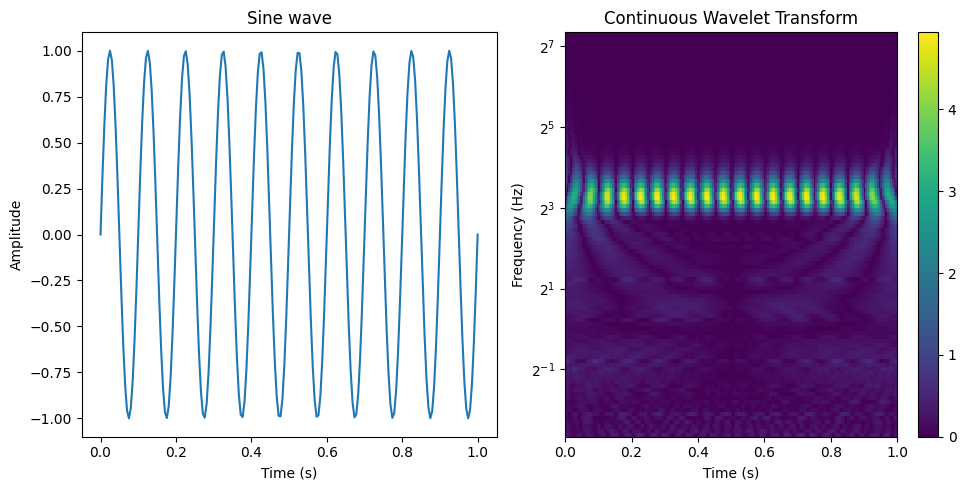

In [24]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

time = np.linspace(0, 1, 200)
sin = np.sin(2*np.pi*time*10)  # 10 Hz sine wave

# Continuous Wavelet Transform
widths = np.geomspace(1, 1024, num=100)
sampling_period = np.diff(time).mean()
coeffs_cwt_r, freqs_cwt = pywt.cwt(sin, widths, 'morl', sampling_period=sampling_period)
coeffs_cwt = np.abs(coeffs_cwt_r[:-1, :-1])

# adjust the figure size
plt.rcParams["figure.figsize"] = (10, 5)

# plot the singal
fig, axs = plt.subplots(1, 2)
axs[0].plot(time, sin)
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Amplitude")
axs[0].set_title("Sine wave")

# plot result using matplotlib's pcolormesh
pcm = axs[1].pcolormesh(time, freqs_cwt, coeffs_cwt)
axs[1].set_yscale("log", base=2)
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Frequency (Hz)")
axs[1].set_title("Continuous Wavelet Transform")
fig.colorbar(pcm, ax=axs[1])

fig.tight_layout()

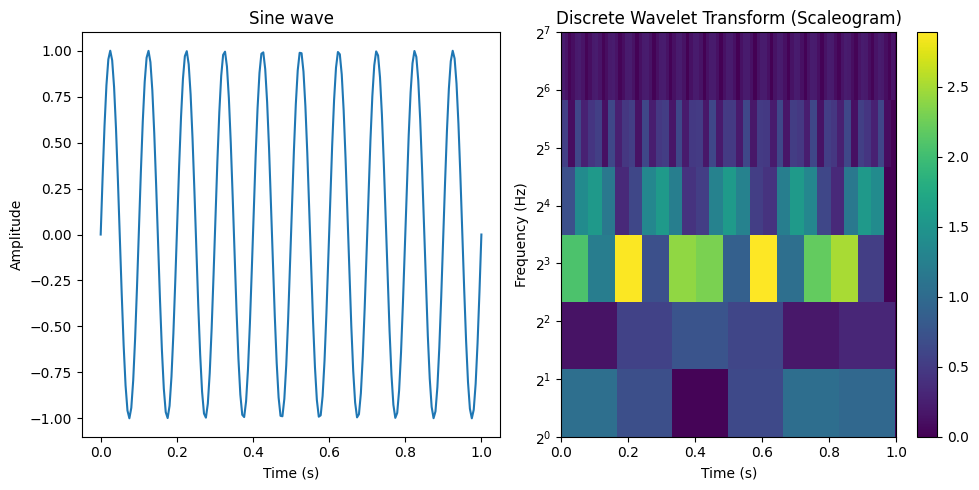

In [15]:
# Discrete Wavelet Transform
level = 5
wavelet = 'db1'
coeffs_dwt = pywt.wavedec(sin, wavelet, level=level)

coeffs_ext = []
duration = len(sin)

for i, coeff in enumerate(coeffs_dwt):
    coeff = np.abs(coeff[:-1])
    factor = duration / len(coeff)
    c_ext = [item for item in coeff for _ in range(int(factor))]
    coeffs_ext.append(c_ext)

# Create a 2D array for the scaleogram
scaleogram = np.zeros((level+1, duration))

# Fill the scaleogram with coefficients
for i, coeff in enumerate(coeffs_ext):        
    scaleogram[i, :len(coeff)] = coeff

scaleogram = scaleogram[:, :duration-1]

# Calculate the frequencies for each level (scales are powers of 2, so freqs are powers of 2)
freqs_dwt = np.logspace(start=0, stop=level+2, num=level+2, base=2)

# adjust the figure size
plt.rcParams["figure.figsize"] = (10, 5)

# plot the singal
fig, axs = plt.subplots(1, 2)
axs[0].plot(time, sin)
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Amplitude")
axs[0].set_title("Sine wave")

# plot result using matplotlib's pcolormesh (image with annoted axes)
pcm = axs[1].pcolormesh(time, freqs_dwt, scaleogram)
axs[1].set_yscale("log", base=2)
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Frequency (Hz)")
axs[1].set_title("Discrete Wavelet Transform (Scaleogram)")
fig.colorbar(pcm, ax=axs[1])

fig.tight_layout()

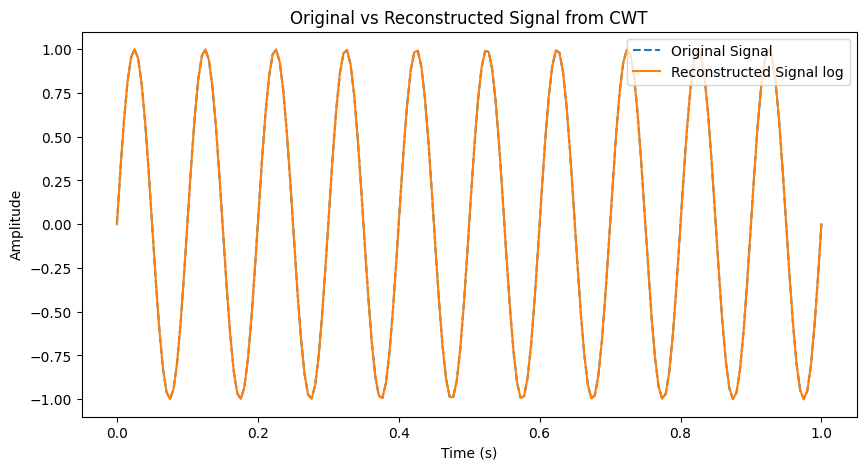

In [ ]:
# Inverse discrete wavelet transform
reconstructed_signal = pywt.waverec(coeffs_dwt, wavelet)

# # plot the singal
# fig, axs = plt.subplots(1, 2)
# axs[0].plot(time, sin)
# axs[0].set_xlabel("Time (s)")
# axs[0].set_ylabel("Amplitude")
# axs[0].set_title("Sine wave")

# # plot the reconstructed signal
# axs[1].plot(time, reconstructed_signal)
# axs[1].set_xlabel("Time (s)")
# axs[1].set_ylabel("Amplitude")
# axs[1].set_title("Reconstructed signal from DWT")

# fig.tight_layout()

plt.figure(figsize=(10, 5))
plt.plot(time, sin, label='Original Signal', linestyle='dashed')
plt.plot(time, reconstructed_signal, label='Reconstructed Signal log')
plt.legend(loc='upper right')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Original vs Reconstructed Signal from CWT")
plt.show()

In [40]:
print(sampling_period)

0.005025125628140704


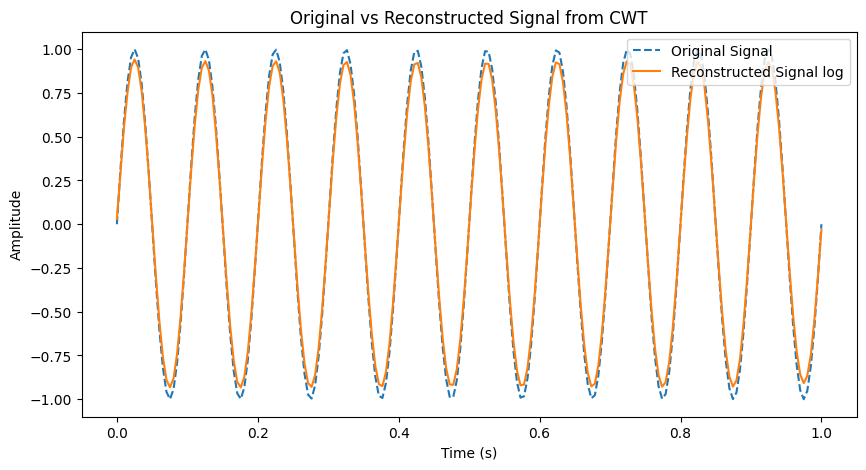

In [50]:
# Reconstruct the signal using ICWT
# ICWT is done by summing over all scales with the proper weighting
# reconstructed_signal = np.sum(coeffs_cwt_r, axis=0) * 20  / np.sqrt(widths[:, None]).sum(axis=0)
reconstructed_signal = np.sum(coeffs_cwt_r / np.sqrt(widths[:, None]), axis=0) / 10

# Plot original and reconstructed signals
plt.figure(figsize=(10, 5))
plt.plot(time, sin, label='Original Signal', linestyle='dashed')
plt.plot(time, reconstructed_signal, label='Reconstructed Signal log')
plt.legend(loc='upper right')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Original vs Reconstructed Signal from CWT")
plt.show()


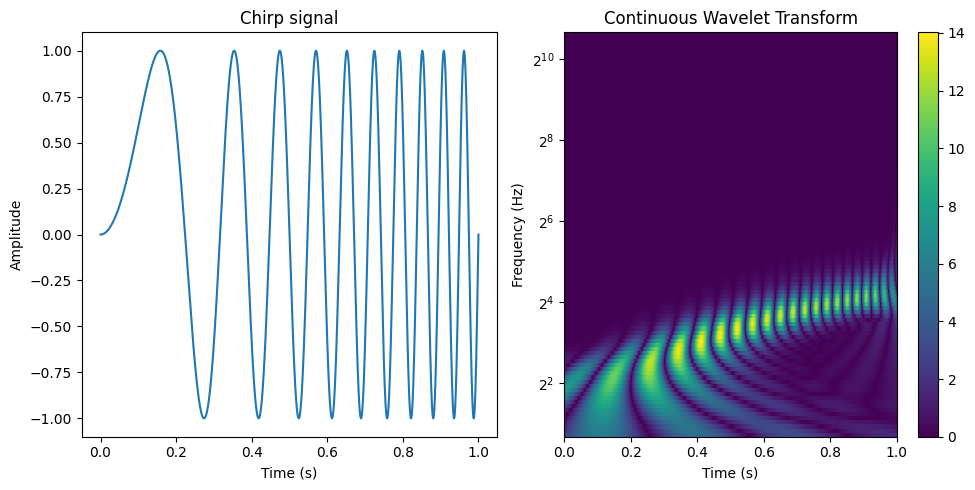

In [39]:
# generate a chirp signal
time = np.linspace(0, 1, 2000)
chirp = np.sin(2*np.pi*10*time**2)

# do the CWT morlet
widths_chirp = np.geomspace(1, 1024, num=100)
sampling_period = np.diff(time).mean()
coeffs_cwt_r, freqs_cwt = pywt.cwt(chirp, widths_chirp, 'morl', sampling_period=sampling_period)
coeffs_cwt = np.abs(coeffs_cwt_r[:-1, :-1])

# adjust the figure size
plt.rcParams["figure.figsize"] = (10, 5)

# plot the singal
fig, axs = plt.subplots(1, 2)
axs[0].plot(time, chirp)
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Amplitude")
axs[0].set_title("Chirp signal")

# plot result using matplotlib's pcolormesh
pcm = axs[1].pcolormesh(time, freqs_cwt, coeffs_cwt)
axs[1].set_yscale("log", base=2)
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Frequency (Hz)")
axs[1].set_title("Continuous Wavelet Transform")
fig.colorbar(pcm, ax=axs[1])

fig.tight_layout()


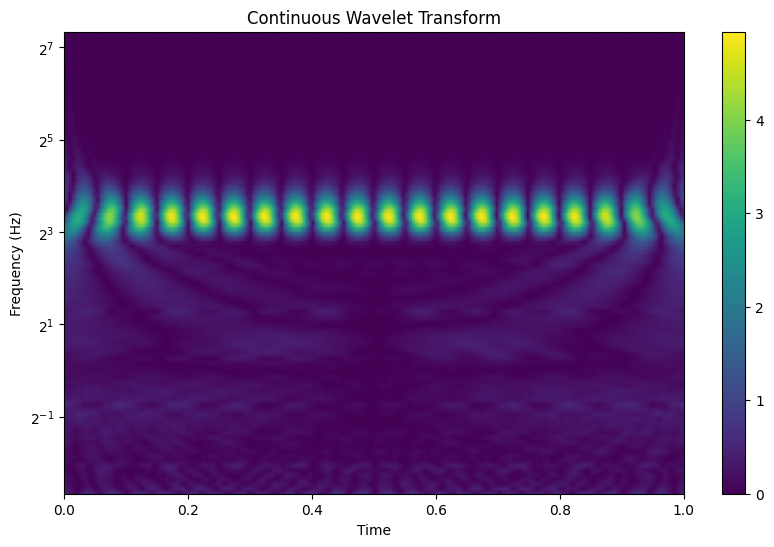

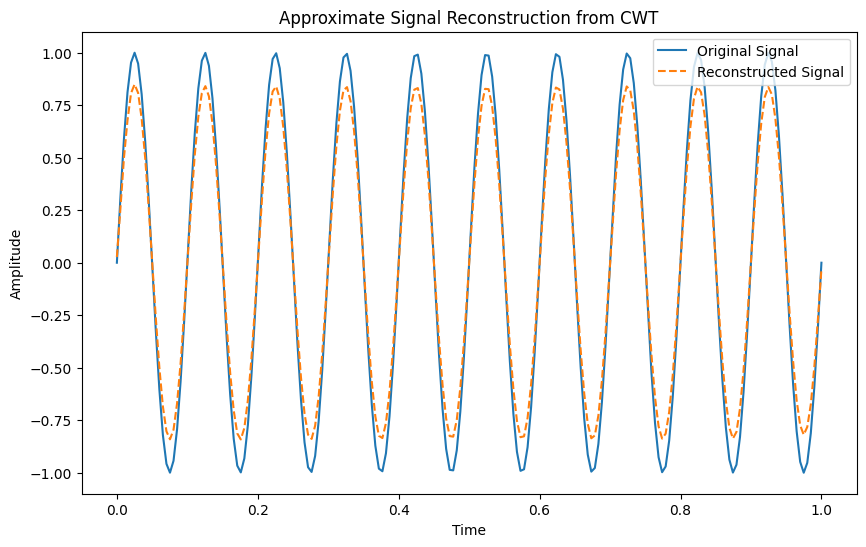

In [36]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

def icwt(cwtmatr, scales, dt, C_psi=0.776, scale='uniform'):
    """
    Approximate inverse continuous wavelet transform.
    
    Parameters:
      cwtmatr : 2D array
          The CWT coefficient matrix (rows: scales, columns: time).
      scales : 1D array
          The scales corresponding to the rows of cwtmatr.
      dt : float
          Sampling period of the original signal.
      C_psi : float, optional
          Admissibility constant for the wavelet (default is 0.776 for typical Morlet parameters).
          
    Returns:
      rec_signal : 1D array
          The reconstructed signal.
    """
    if scale == "uniform":    
        dj = scales[1] - scales[0]
    elif scale == "log":
        dj = (np.log(scales[-1]) - np.log(scales[0])) / (len(scales) - 1)
    
    # Sum over scales using the inversion formula:
    rec_signal = np.sum(np.real(cwtmatr) / np.sqrt(scales[:, None]), axis=0)
    
    # Multiply by the constant factors:
    # rec_signal *= (dt * np.sqrt(2 * np.pi) * dj) / C_psi
    rec_signal *= (dj) / C_psi
    
    return rec_signal

# Create a sample signal: a sine wave with a frequency of 10 Hz.
t = np.linspace(0, 1, 200)
freq = 10  # Hz
signal = np.sin(2 * np.pi * freq * t)

# Choose a complex Morlet wavelet; here using PyWavelets' cmor wavelet.
wavelet = 'morl'

widths = np.geomspace(1, 1024, num=100)

# sampling period of a geomspaced signal

# Compute the Continuous Wavelet Transform (CWT)
sampling_period = t[1] - t[0] # sampling period

coef, freqs = pywt.cwt(signal, widths, wavelet, sampling_period)

# plot the CWT scaleogram
plt.figure(figsize=(10, 6))
plt.pcolormesh(t, freqs, np.abs(coef), shading='gouraud')
plt.colorbar()
plt.yscale('log', base=2)
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.title('Continuous Wavelet Transform')
plt.show()

# Reconstruct the signal using the logarithmic-scale inversion function.
rec_signal = icwt(coef, widths, sampling_period, C_psi=0.776, scale='log')

# Plot the original and reconstructed signals.
plt.figure(figsize=(10, 6))
plt.plot(t, signal, label='Original Signal')
plt.plot(t, rec_signal, label='Reconstructed Signal', linestyle='--')
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Approximate Signal Reconstruction from CWT")
plt.legend(loc='upper right')
plt.show()


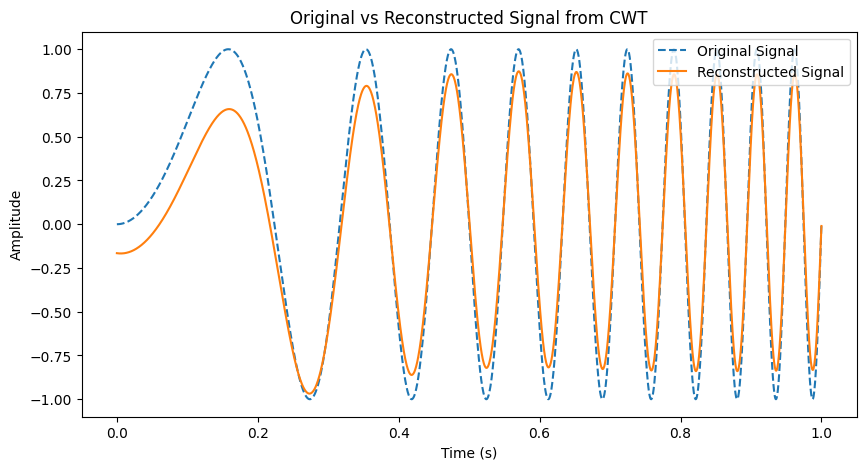

In [41]:
# reconstruct the signal using ICWT
reconstructed_signal_chirp = icwt(coeffs_cwt_r, widths_chirp, sampling_period, scale='log')

# plot original and reconstructed signals
plt.figure(figsize=(10, 5))
plt.plot(time, chirp, label='Original Signal', linestyle='dashed')
plt.plot(time, reconstructed_signal_chirp, label='Reconstructed Signal')
plt.legend(loc='upper right')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Original vs Reconstructed Signal from CWT")
plt.show()